## PHYS 366 Final Project
---
#### Sean McLaughlin

In this project I will attempt to infer the Mass-Richness relation for Galaxy clusters. I will begin by building a model and a functional relationship amongst the parmaters. After, I will generate some mock data and compare it to some real data I have access to. If that is all successful, I will infer the parameters with MCMC. 

## The Model
---

### Basics
---

The richness of a galaxy cluster (a measure of how populated the cluster is) is related to the mass of the cluster's halo by the assumed relation:

$\lambda(a,b)  = a M^b+\sigma$

Where $\sigma$ is some insofar undefined intrinsic scatter. We will most likely try a lognormal relation, but there are other options to try. Our only data in this example is a collection of observed richnesses. We also have redshifts, which in a more complex model would be observed, but in this base case we will assume is given. 

The dark matter mass (obviously) cannot be observed. However, the mass function gives us a distribution of masses given only a redshift and cosmological information. The mass function will have to be carefully chosen.


### PGM
---
This model has the following PGM.

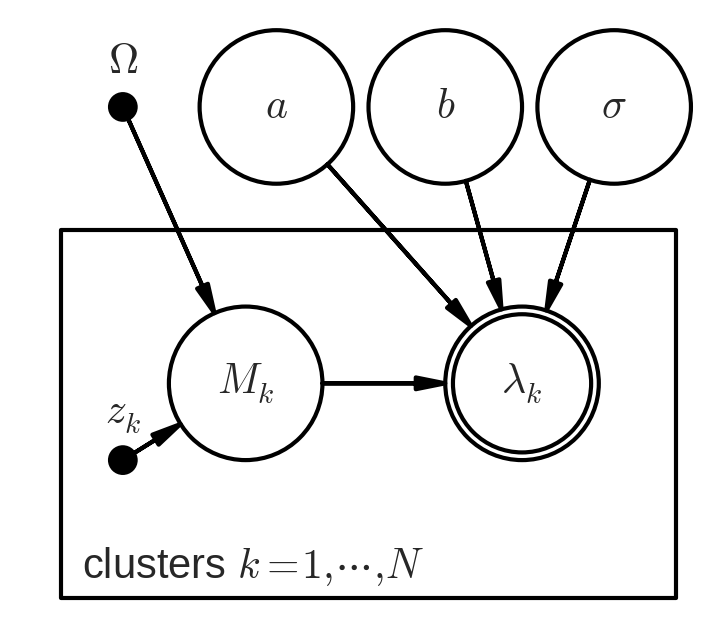

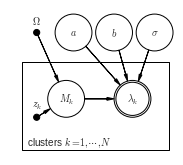

In [227]:
import daft

pgm = daft.PGM([2.3, 2.05], origin=[.3,.3], grid_unit = 2.6, node_unit=1.3, observed_style="inner")

pgm.add_node(daft.Node("cosmology", r"$\Omega$", .7,2,fixed =True))

pgm.add_node(daft.Node("scatter", r"$\sigma$", 2.3, 2))
pgm.add_node(daft.Node("b", r"$b$", 1.75, 2))
pgm.add_node(daft.Node("a", r"$a$", 1.2, 2))

pgm.add_node(daft.Node("redshift", r"$z_k$", 0.7,.85,fixed =True))
#pgm.add_node(daft.Node("class", r"$c_k$", 0.7, 1.35, fixed = True))

pgm.add_node(daft.Node("Mcluster", r"$M_k$", 1.1,1.1))

pgm.add_node(daft.Node("richness", r"$\lambda_k$", 2,1.1,observed=True))

pgm.add_edge("a", "richness")
pgm.add_edge("b", "richness")
pgm.add_edge("scatter", "richness")
pgm.add_edge("Mcluster", "richness")

pgm.add_edge("redshift", "Mcluster")
#pgm.add_edge("class", "Mcluster")
pgm.add_edge("cosmology", "Mcluster")

pgm.add_plate(daft.Plate([.5,.5,2,1.1], label=r"clusters $k=1, \cdots, N$", shift = -.1))

pgm.render()
pgm.figure.savefig("modelPGM2.png", dpi = 300)
from IPython.display import Image
Image("modelPGM2.png")

This model reveals a few assumptions that have been made. I've assumed that in addition to the individual cluster redshifts being fixed, the cosmology $\Omega$ is also fixed. We could unfix it and choose to infer both the relation parameters and and the cosmology, or fix the parameters to focus just on the cosmology. Those options will be revisited later. We've also assumed at this point that all richnesses have been observed perfectly. Measrement error and/or shot noise will have to be added in as well. 

This PGM decomposes to the distribution:

$P(a,b,\sigma |\; \Omega, \{z\}, \{\lambda\}) = \int{\prod_{k=1}^N{P(\lambda_k |\; M_k, a,b,\sigma) \; P(M_k |\; z_k, \Omega)\; P(a,b,\sigma)\; dM_k}} $

Out of the gate it's easy to see the most challenging part will be the N-dimensional integral of all the cluster masses. 

### Individual distributions
-----

These will have to be revisited, possibly several times to get them right. I'll start as simple as I can and build forward from there. 

$P(\lambda_k |\; M_k, a,b,\sigma)$:

I'll assume deviations from the main relation are lognormally distributed. So, 

$\mathcal{l} \;(\lambda_k | \; M_k, a,b,\sigma)  = \frac{-(\mu-\log(\lambda_k))^2}{2\;\sigma^2}-\log(\sigma \; \lambda_k)-\log(\sqrt{2\pi}) $

With $\mu$ defined as:

$\mu = \log(a M_k ^ b) = b\;\log(a M_k) $

-----
$P(M_k |\; z_k, \Omega)$: 

We can use the mass function as an unormalized PDF for how likely a certain cluster mass its redshift. The standard form is the Tinker mass function, given by:

$n_{Tinker}(M,z) = \frac{dn}{dM} = \frac{\bar{\rho}_m(z)}{M}\frac{d\log{\sigma^{-1}(M,z)}}{dM}f(\sigma,z) $

Where $\bar{\rho}_m$ is the mean comoving matter density and $\sigma^2$ is the variance of the linearly evolved density field. $f(\sigma, z)$ is an anlytic fitting function, generally of the form:

$f(\sigma, z) = A\left[\left(\frac{\sigma}{b}\right)^{-a}+1\right]e^{-c/\sigma^2}$

Where $\{A,a,b,c\}$ are allowed to vary as a power law of $(1+z)^\alpha$. 

However, it was proposed by Evrard et al that this function can be well approximated by a taylor expansion in the exponential. 

$n_i = A \exp{-\sum_{j=1}^i{\beta_j \mu^j/{j!}}}$

Where $\mu \equiv M/M_p$ for some $M_p$ and the remaining parameters are computed explicitly. The trouble is, in this paper those parameters are only computed for 2 redshifts, z = 0.23 and 1.5. I'd very much like to use the above as my liklihood as it's trivial to make a log-liklihood from it. However, I don't know how to get the parameters for in between redshifts. I suppose that also brings up the question that I don't know what redshifts I'd want to compute this for. Let's plot up some simulations to see what the distribution is like.

In [228]:
from astropy.io import fits
hdulist = fits.open('/home/sean/Downloads/Buzzard-highres_galaxies_shmatch.9951.fit')
dataTable = hdulist[1]
trueData = dataTable.data
#trueData = trueData[trueData['CENTRAL']==1]# only interested in centrals

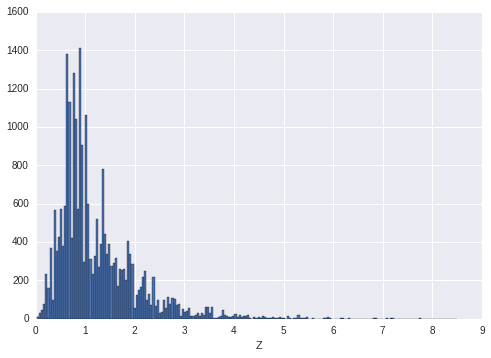

In [229]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import numpy as np

plt.hist(trueData['Z'], bins = 200)
plt.xlabel("Z")
plt.show()

#sns.jointplot(np.log10(trueData['M200']), trueData['Z'], kind = 'kde')
#Sorry no axes labels, x is logM200 and y is redshift

By the look of it, though there are some clusters out to z = 8, most of them are at a redshift less than 2. I'll ask for a suggestion, but what I'll probably do is put a line between the values I have and select params from them when doing my selections. So, after much discussion, 

$\mathcal{l}(M) = -\sum_{j=1}^i{\frac{\beta_j}{j!} \left(\frac{M}{M_p}\right)^j}+\log{A}$

----

$P(a,b,\sigma)$:
I wrote the prior on parameters above together for notationaly simplicity. However, they will each be independant, so deconstruct to:

$P(a)\;P(b)\;P(\sigma)$

For $a$, we know little except that it must be greater than 0 since there can be know negative richness. Since in the log-log plot $\log{a}$ is the intercept of the "line", so we can think about how we would want that to be distributed. A uniform distribution on $\log{a}$ may be a good idea. However , that will acutally probably bias $a$ to exponentially large values. Better instead may be an exponential in $\log(a)$ which would be approximatley uniform in $a$. This has one hyperparameter to tune, $\lambda$. 

$\mathcal{l}(\alpha) = \mathcal{l}(\log{a}) = \log{\lambda} - \lambda \log{a}$

For $b$, we know about the same. Physically, we know it must be greater than 0. On a log-log plot, $b$ is the slope of the line of best fit. Then, perhaps distribution that favors all angles of that line equally will be a good choice. So, we'll define

$b \equiv \tan(\theta)$

And insist $\theta \thicksim U(0, \frac{\pi}{2})$ such that

$\mathcal{l}(\theta) =\mathcal{l}(\arctan(b)) = \log(\frac{2}{\pi})$

Lastly, is the prior for $\sigma$. We have a few choices here. $\sigma$ needs to be invariant to scaling, so $\mathcal{l} \propto 1/\sigma$ is a good choice. However, since that is an improper prior there may be trouble later. Another choice is the inverse gamma distribution. It is the conjugate prior for the log-Normal distribution. It has 2 hyper parameters $\alpha$ and $\beta$, which is a lot to tune. For now, I'll go with the gamma because the additional tuning may help me find the right scatter for my mock data. If tuning is an issue later I will return with a simpler prior. I'll also see if I can make use of the conjugate properties. 

$\mathcal{l}(\sigma) = -\log{\Gamma(\sigma | \alpha, \beta)} $

### Mock Data
----

Ok, that was a bear. Now let's sample some mock data from this distribution to see how it looks. First, I'll select a random set from the catalog I have, and look at their mass, richness and redshifts. 

In [230]:
dataSample = trueData[np.random.choice(trueData.shape[0], size = 1000, replace = False)]
dataSample.columns.info()

name:
    ['ID', 'ECATID', 'OMAG', 'AMAG', 'Z', 'RA', 'DEC', 'PX', 'PY', 'PZ', 'VX', 'VY', 'VZ', 'EDGE', 'HALOID', 'M200', 'NGALS', 'R200', 'RHALO', 'CENTRAL', 'MSTAR', 'D8', 'NNDIST', 'NNPERCENT']
format:
    ['J', 'J', '5E', '5E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'I', 'J', 'E', 'I', 'E', 'E', 'I', 'E', 'E', 'E', 'E']
unit:
    ['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
null:
    ['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
bscale:
    ['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
bzero:
    ['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
disp:
    ['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
start:
    ['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
dim:
    ['', '', '',

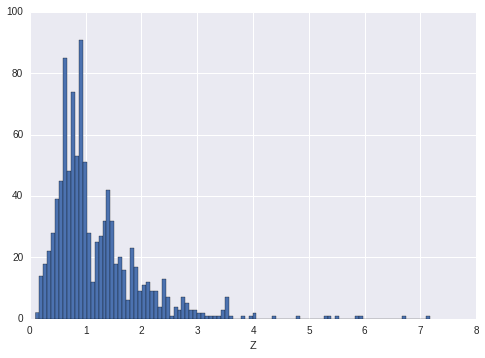

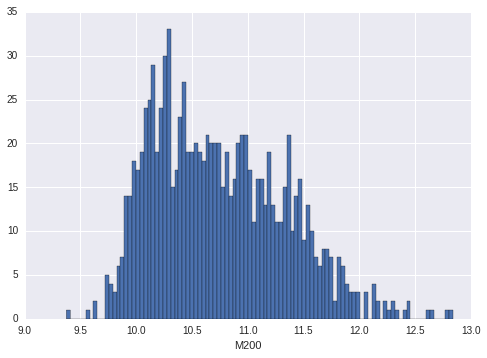

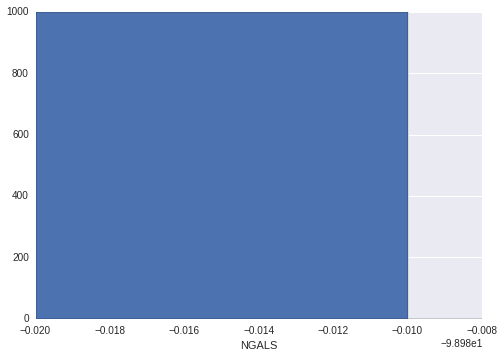

In [231]:
for column in ['Z', 'M200', 'NGALS']:
    if column == 'M200':
        plt.hist(np.log10(dataSample[column]), bins = 100)
    else:
        plt.hist(dataSample[column], bins = 100)
    plt.xlabel(column)
    plt.show()

Well crap. NGals isn't useful for this, I'll need another catalog for richnesses. Queue Redmapper. Also I'm fairly certain these aren't cluster halos

In [247]:
hdulist = fits.open('/home/sean/Downloads/Buzzard-highres_v1.0_redmapper_lgt20_catalog.fit')
redmapperData = hdulist[1].data
print redmapperData.columns.info()

name:
    ['MEM_MATCH_ID', 'RA', 'DEC', 'MODEL_MAG', 'MODEL_MAGERR', 'IMAG', 'IMAG_ERR', 'ZRED', 'ZRED_E', 'ZRED_CHISQ', 'BCG_SPEC_Z', 'Z_SPEC_INIT', 'Z_INIT', 'Z', 'LAMBDA_CHISQ', 'LAMBDA_CHISQ_E', 'LAMBDA_ZRED', 'LAMBDA_ZRED_E', 'R_LAMBDA', 'SCALEVAL', 'MASKFRAC', 'C_LAMBDA', 'C_LAMBDA_ERR', 'MAG_LAMBDA_ERR', 'CHISQ', 'Z_LAMBDA', 'Z_LAMBDA_E', 'Z_LAMBDA_NITER', 'EBV_MEAN', 'LNLAMLIKE', 'LNBCGLIKE', 'LNLIKE', 'PZBINS', 'PZ', 'NCROSS', 'RMASK', 'RA_ORIG', 'DEC_ORIG', 'W', 'DLAMBDA_DZ', 'DLAMBDA_DZ2', 'DLAMBDAVAR_DZ', 'DLAMBDAVAR_DZ2', 'LAMBDA_CHISQ_C', 'LAMBDA_CHISQ_CE', 'NCENT', 'NCENT_GOOD', 'RA_CENT', 'DEC_CENT', 'ID_CENT', 'LAMBDA_CHISQ_CENT', 'ZLAMBDA_CENT', 'P_BCG', 'P_CEN', 'Q_CEN', 'P_FG', 'Q_MISS', 'P_SAT', 'P_C', 'BCG_ILUM', 'ILUM', 'Z_LAMBDA_RAW', 'Z_LAMBDA_E_RAW', 'LIM_EXPTIME', 'LIM_LIMMAG', 'LIM_LIMMAG_HARD']
format:
    ['J', 'D', 'D', '4E', '4E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', '3E', '3E', '4E', 'E', 'E', 'E', 'I', 'E', 'E

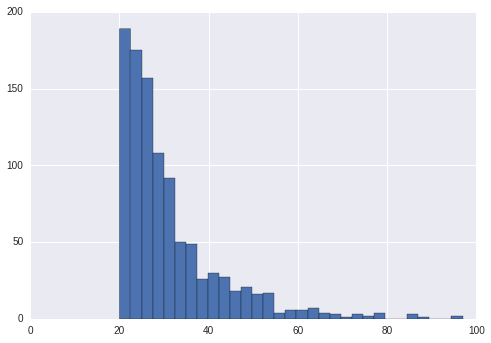

In [233]:
plt.hist(redmapperData['LAMBDA_CHISQ'], bins = int(np.sqrt(redmapperData.shape[0])));
plt.xlim([0,100]);

There's a hard cutoff at 20, I didn't realize that. That explains why my mock data wasn't looking good before. 

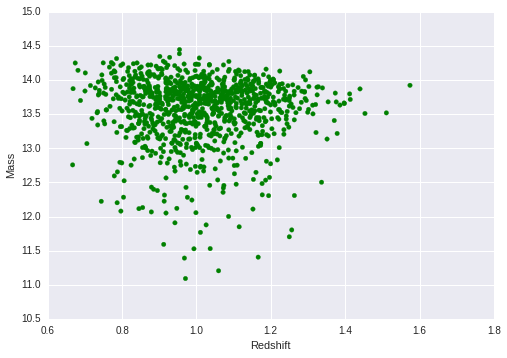

In [241]:
#draw parameters from priors
nSamples = 1000
data_color = 'g'
#don't need to be sampled but i'll need some anyway
#z_samples = np.random.lognormal(mean = mu_z, sigma = sig_z, size = nSamples )
#redshift cannot be greater than 2
z_samples = np.random.lognormal(0,.15, size = nSamples )

Mmax = 3#Masses need to be rescaled. 

#gonna have to hardcode the mass sampler. 
#First, will need the parameters
vals = {}
z = [0.23, 1.5]
vals['Mp'] = [2.0, 1.0]#*10^14
vals['A'] = [1.944, 0.293]
vals['B1'] = [1.97, 3.07]
vals['B2'] = [0.7, 1.2]
vals['B3'] = [0.40, 0.73]

z_params = {}
from scipy.stats import linregress
for key, val in vals.iteritems():
    slope, intercept, r, p, stderr = linregress(z, val)
    z_params[key] = (slope, intercept)
    
def getMassParams(z):
    return {key:val[0]*z+val[1] for key,val in z_params.iteritems()}

def n_approx(m,z):
    params = getMassParams(z)
    return params['A']*np.exp(-params['B1']*(m/params['Mp']) \
                    -0.5*params['B2']*(m/params['Mp'])**2 \
                    -0.166*params['B3']*(m/params['Mp'])**3)

mSamples = np.zeros((nSamples,)) #*10^14
for i, z in enumerate(z_samples):    
    #have to normalize the pdf for this z. ugh. 
    norm = np.trapz(n_approx(np.linspace(0,Mmax,1000),z), dx = 1.0/500)
    done = False
    while not done:
        M = np.random.uniform(0,Mmax)# ask about range here
        if n_approx(M,z)>np.random.uniform(0,norm):
            done = True
    mSamples[i] = M*10**14
    
logmSamples = np.log10(mSamples)

plt.scatter(z_samples,logmSamples, color = data_color)
plt.ylabel('Mass')
plt.xlabel('Redshift')

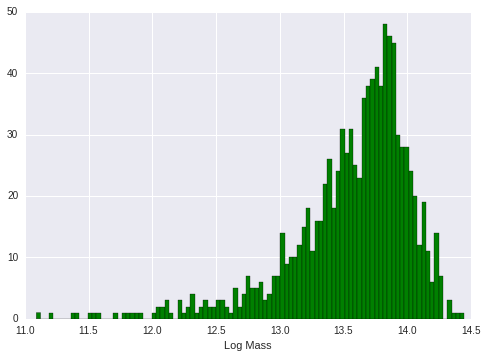

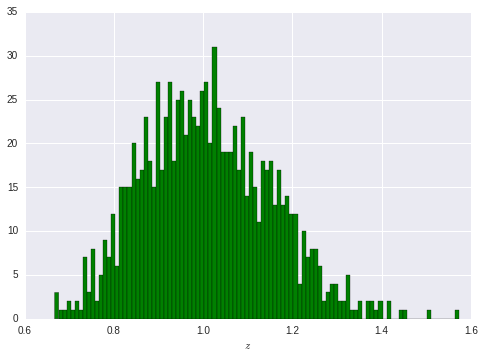

In [242]:
plt.hist(logmSamples, 100, color = data_color)
plt.xlabel('Log Mass')
plt.show()
plt.hist(z_samples, 100, color = data_color)
plt.xlabel('$z$')

(20, 100)

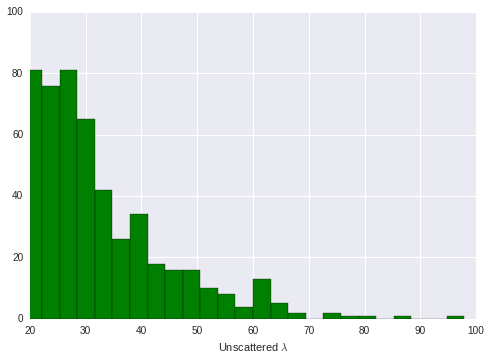

In [243]:
a,b = 5e-12,.92
mean = a*pow(mSamples,b)

plt.hist(mean, bins = np.sqrt(nSamples), color = data_color)
plt.xlabel('Unscattered $\lambda$')
plt.xlim([20,100])


(20, 100)

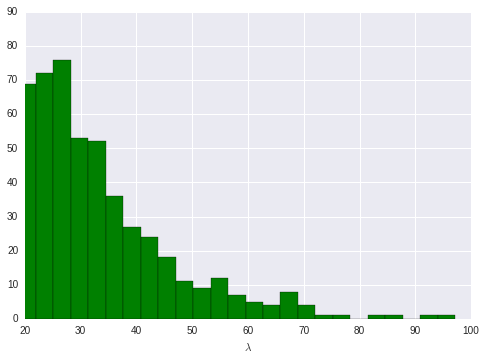

In [246]:
sigma = .1
lambda_samples = np.random.lognormal(mean = np.log(mean),sigma = sigma)
plt.hist(lambda_samples, bins = np.sqrt(nSamples), color = data_color )
plt.xlabel('$\lambda$')
plt.xlim([20,100])

Thus far mock data is a bust. I can't get the power law to have the same floor as the richness in the other problem. Rather than keep guessing, I'll work on the regression for now.

### Parameter Inference

I'll use MCMC to do the inference. Since I've defined everything already it should be fairly easy to code up. 

In [287]:
from scipy.stats import gamma
def log_prior(a,b,sigma):
    #Hyperparameters
    lambda_a = 1
    sigma_a, sigma_b = 1,1
    p = 0
    
    #Exponential in log a
    p+= np.log(lambda_a)+lambda_a*np.log(a)
    #Uniform in arctan(b)
    p+=np.log(2/np.pi)
    #Inv Gamma for sigma
    p-= gamma.logpdf(sigma,sigma_a, scale = sigma_b)
    
    return p

def log_liklihood(rich, M, a,b,sigma,z):
    p = 0
    #Mass
    p+=np.log(n_approx(M,z))#not normalized, if that's a problem i can approximate it. 
    #richness
    print p
    p-= np.sum(((b*np.log(a*M)-np.log(rich))**2)/(2*sigma**2)-np.log(sigma*rich))
    print p
    return p

def log_posterior(theta,rich,z):
    a,b,simga,M = theta
    p = log_prior(a,b,sigma)
    print p
    if np.isfinite(p):
        p+=log_liklihood(rich,M,z,a,b,sigma)
    print p
    print '*'*50
    return p

In [292]:
ndim, nwalkers = 4, 500
rich = redmapperData['LAMBDA_CHISQ']
redshifts = redmapperData['ZRED']

a_mean, a_spread = 1e-11, 2e-12
b_mean, b_spread = 1, .01
sigma_mean, sigma_spread = 1, .01
logM_mean, logM_spread = 14, 1 #lognormal for this one

pos0 = np.zeros((nwalkers, ndim))
for row in pos0:
    #a,b,sigma,m
    pos0[0] = a_mean+np.random.randn()*a_spread
    pos0[1] = b_mean+np.random.randn()*b_spread
    pos0[2] = sigma_mean+np.random.randn()*sigma_spread
    pos0[3] = 10**(logM_mean+np.random.randn()*logM_spread)

In [293]:
import emcee as mc
sampler = mc.EnsembleSampler(nwalkers, ndim, log_posterior, args=[rich, redshifts])
nsteps = 100

In [296]:
sampler.run_mcmc(pos0, nsteps)

-24.9801705313
0.748108738616
-1.4551942341e+25
-1.4551942341e+25
**************************************************
-0.348265108619
-0.218803659196
-4653.48101069
-4653.8292758
**************************************************
-0.343281130624
-0.224072291841
-4560.1952637
-4560.53854483
**************************************************
35.6199901491
-inf
-inf
-inf
**************************************************
-inf
-inf
**************************************************
-inf
-inf
**************************************************
-inf
-inf
**************************************************
-inf
-inf
**************************************************
-inf
-inf
**************************************************
-inf
-inf
**************************************************
-inf
-inf
**************************************************
-inf
-inf
**************************************************
-inf
-inf
**************************************************
-inf
-inf
********************

ValueError: lnprob returned NaN.

In [295]:
chain = sampler.chain
from corner import corner
corner(chain)

AssertionError: The input sample array must be 1- or 2-D.